In [1]:
import time
from PIL import Image, ImageDraw
from PIL import Image
import PIL
from PIL import *
from tkinter import *
import math
import numpy
import scipy.ndimage
import scipy.special
import scipy.misc
import matplotlib.pyplot
%matplotlib inline

In [2]:
# определение класса нейронной сети
class neuralNetwork:
    
    # инициализировать нейронную сеть
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # задать количество узлов во входном, скрытом и выходном слое
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # коэфицент обучения
        self.lr = learningrate
        
        # wih (весовые коэфиценты входного и скрытого слоя)
        # who (весовые коэфиценты скрытого и выходного слоя)
        self.wih = numpy.random.normal(0.0, pow(self.hnodes, -0.5),(self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.onodes, -0.5),(self.onodes, self.hnodes))
        
        # определение функции активации
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
        
        pass
    
    # тренировка нейронной сети
    def train(self, inputs_list, target_list):
        # преобразовать список входных значений в двумерный массив
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(target_list, ndmin=2).T
        
        # рассчитать входящие сигналы для скрытого слоя
        hidden_inputs = numpy.dot(self.wih, inputs)
        # рассчитать исходящие сигналы для скрытого слоя
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # рассчитать входящие сигналы для выходного слоя
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # рассчитать исходящие сигналы для выходного слоя
        final_outputs = self.activation_function(final_inputs)
        
        # ошибка = целефое значение - фактическое значение
        output_errors = targets - final_outputs
        
        # ошибки скрытого слоя - это ошибки output_errors
        # распределение пропроционально весовым коэфицентам связей
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        # обновить весовые коэфиценты связей между скрытым и выходным слоями
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        
        # между входным и скрытым слоями
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        
        pass
    
    # опрос нейронной сети
    def query(self, inputs_list):
        #преобразовать спсиок в двумерный массив
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # рассчитать входящие сигналы для скрытого слоя
        hidden_inputs = numpy.dot(self.wih, inputs)
        # рассчитать исходящие сигналы для скрытого слоя
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # рассчитать входящие сигналы для выходного слоя
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # рассчитать исходящие сигналы для выходного слоя
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    
    # backquery the neural network
    # we'll use the same termnimology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [3]:
# количество входных, скрытых и выходных узлов
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# коэфицент обучения
learning_rate = 0.01

# создать экземпляр неронной сети
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [4]:
# загрузка тренировачного списка
training_data_file = open("mnist_dataset/mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [5]:
# тренировка нейронной сети

# epochs определяет количество тренировок "Эпох"
epochs = 10

for e in range(epochs):
    for record in training_data_list:
        # получение списка значений
        all_values = record.split(',')

        # инвертирование в числа, масштабирование, смещение
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        
        # создание тренировачного варианта поворотом изображения (10 градусов и -10 градусов)
        inputs_plusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), 10, cval=0.01, order=1, reshape=False)
        inputs_minusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), -10, cval=0.01, order=1, reshape=False)

        # подготовка требуемого результата
        targets = numpy.zeros(output_nodes) + 0.01
        targets[int(all_values[0])] = 0.99

        # запуск обучения
        n.train(inputs_plusx_img.reshape(784), targets)
        n.train(inputs_minusx_img.reshape(784), targets)
        n.train(inputs, targets)
        
        pass
    pass

In [6]:
# загрузка тестового набора
test_data_file = open("mnist_dataset/mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [7]:
# тестирование нейронной сети
# журнал оценок работы сети
scorecard = []

# перебрать все записи в тестовом наборе данных
for record in test_data_list:
    
    # получение списка значений
    all_values = record.split(',')
    
    # правильный ответ
    correct_label = int(all_values[0])
    # print(correct_label, "истинный маркер")
    
    # инвертирование в числа, масштабирование, смещение
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    
    # опрос сети
    outputs = n.query(inputs)
    
    # индекс наибольшего значения является маркерным значением
    label = numpy.argmax(outputs)
    # print(label, "ответ сети")
    
    # заполнение отчета теста
    if (label == correct_label):
        # прибивляем к списку 1
        scorecard.append(1)
    else:
        scorecard.append(0)
        pass
    pass

    

In [8]:
# расчет показателя эффективности
scorecard_array = numpy.asarray(scorecard)
print ("эффективность = ", scorecard_array.sum() / scorecard_array.size)

эффективность =  0.9774


In [9]:
class Paint(Frame):
    # Создание фрейма
    def __init__(self, parent):
        Frame.__init__(self, parent)
        self.parent = parent
        self.brush_size = 7
        self.color = "black"
        self.setUI()
        pass
    
    def draw(self, event):
        # Нанесение кругов на холст
        self.canv.create_oval(event.x - self.brush_size, event.y - self.brush_size, event.x + self.brush_size, event.y + self.brush_size, fill=self.color, outline=self.color)
        self.draw.ellipse([event.x - self.brush_size, event.y - self.brush_size, event.x + self.brush_size, event.y + self.brush_size], fill=self.color, outline=self.color)
        pass
    
    def setUI(self):
        # Устанавливаем название окна
        self.parent.title("Нейронная сеть определения чисел")
        # Размещаем активные элементы на родительском окне
        self.pack(fill=BOTH, expand=1)
        self.width = 280
        self.height = 280
        
        # Создаем поле для рисования, устанавливаем белый фон
        self.canv = Canvas(self, bg="white")
        self.canv.config(width=self.width, height=self.height)
        # Прикрепляем канвас методом grid
        self.canv.grid(row=0, column=0, rowspan=3, padx=5, pady=5)
        self.canv.bind("<B1-Motion>", self.draw)
        
        #IMG невидимый
        self.image1 = PIL.Image.new("RGB", (self.width, self.height), "white")
        self.draw = ImageDraw.Draw(self.image1)

        # Создаем метку для ответа
        self.answer = Label(self, text="Нарисуйте цифру", font=("Helvetica", 16))
        self.answer.grid(row=1, column=2, padx=6)

        # Создание кнопки:  Установка текста кнопки, задание ширины кнопки (10 символов)
        check = Button(self, text="→", width=5, font=("Helvetica", 24), command=self.check_la)
        # Устанавливаем кнопку первый ряд, вторая колонка
        check.grid(row=1, column=1)

        # Создание кнопки очистки холста
        clear_btn = Button(self, text="Очистить холст", width=15, command=self.clear) 
        clear_btn.grid(row=3, column=0, padx=5, ipady=10)
        pass
    
    def clear(self):
        # Процедура очистки
        self.image1 = PIL.Image.new("RGB", (self.width, self.height), "white")
        self.draw = ImageDraw.Draw(self.image1)
        self.canv.delete("all")
        pass

    def check_la(self):
        # получение списка значений
        #filename = "my_drawing.png"
        #self.image1.save(filename)
        #img_array = scipy.misc.imread("my_drawing.png", flatten=True)
        
        img_array = numpy.asarray(self.image1)
        
        min_img = numpy.zeros((28, 28))
        for i in range(28):
            for j in range(28):
                sum = 0
                for y in range(10):
                    for x in range(10):
                        for z in range(3):
                            sum += img_array[y+(i*10),x+(j*10),z]
                            pass
                        pass
                    pass
                min_img[i,j] = (sum/300)
                pass
            pass
        matplotlib.pyplot.imshow(min_img, interpolation="nearest")

        min_img_invert = 255.0 - min_img.reshape(784)

        # инвертирование в числа, масштабирование, смещение
        inputs = (numpy.asfarray(min_img_invert) / 255.0 * 0.99) + 0.01
    
        # опрос сети
        print(numpy.mean(inputs))
        outputs = n.query(inputs)

        #for d in outputs:
        #    print("%.4f" % (d))
        #    pass
        #print("end")
        # индекс наибольшего значения является маркерным значением
        label = numpy.argmax(outputs)
        #print(label)
        self.answer['text'] = "Это число: " + str(label)
        pass

def main():
    # Создание окна
    root = Tk()
    root.geometry("600x350+300+300")
    app = Paint(root)
    root.mainloop()
    pass

In [12]:
# Окно для рисования и определения цифры
# Виджеты только на главном окне
if __name__ == "__main__":
    main()
    pass

[0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


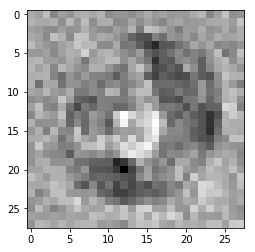

In [11]:
# run the network backwards, given a label, see what image it produces

# label to test
label = 0
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')